In [1]:
import argparse

import os.path as osp
import time

import torch
import torch.nn.functional as F

import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.logging import init_wandb, log
from torch_geometric.nn import GCNConv

import sys
sys.argv = ['GCN.ipynb']


In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default='Cora')
parser.add_argument('--hidden_channels', type=int, default=16)
parser.add_argument('--lr', type=float, default=0.01)
parser.add_argument('--epochs', type=int, default=200)
parser.add_argument('--use_gdc',  action='store_true', help='Use GDC')
parser.add_argument('--wandb', action='store_true', help='Track experiment')
args = parser.parse_args()

这是因为调用parser.parse_args()会读取系统参数：sys.argv[]，命令行调用时是正确参数，而在jupyter notebook中调用时，sys.argv的值为ipykrnel_launcher.py：

In [3]:
args

Namespace(dataset='Cora', hidden_channels=16, lr=0.01, epochs=200, use_gdc=False, wandb=False)

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

In [5]:
init_wandb(
    name=f'GCN-{args.dataset}',
    lr = args.lr,
    epochs=args.epochs,
    hidden_channels=args.hidden_channels,
    device=device,
)

In [6]:
path = osp.join('D:\courses23fall\computational_finance\a2', '..', 'data', 'Planetoid')
dataset = Planetoid(path, args.dataset, transform=T.NormalizeFeatures())
data = dataset[0].to(device)

In [7]:
if args.use_gdc:
    transform = T.GDC(
        self_loop_weight=1,
        normalization_in='sym',
        normalization_out='col',
        diffusion_kwargs=dict(method='ppr', alpha=0.05),
        sparsification_kwargs=dict(method='topk', k=128, dim=0),
        exact=True,
    )
    data = transform(data)

In [8]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [9]:
dataset

Cora()

In [10]:
import numpy as np
data.train_mask

tensor([ True,  True,  True,  ..., False, False, False], device='cuda:0')

In [11]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels,
                             normalize=not args.use_gdc)
        self.conv2 = GCNConv(hidden_channels, out_channels,
                             normalize=not args.use_gdc)

    def forward(self, x, edge_index, edge_weight=None):
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        return x


model = GCN(
    in_channels=dataset.num_features,
    hidden_channels=args.hidden_channels,
    out_channels=dataset.num_classes,
).to(device)

optimizer = torch.optim.Adam([
    dict(params=model.conv1.parameters(), weight_decay=5e-4),
    dict(params=model.conv2.parameters(), weight_decay=0)
], lr=args.lr)  # Only perform weight-decay on first convolution.


def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_attr)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test():
    model.eval()
    pred = model(data.x, data.edge_index, data.edge_attr).argmax(dim=-1)

    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        accs.append(int((pred[mask] == data.y[mask]).sum()) / int(mask.sum()))
    return accs


best_val_acc = test_acc = 0
times = []
for epoch in range(1, args.epochs + 1):
    start = time.time()
    loss = train()
    train_acc, val_acc, tmp_test_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    log(Epoch=epoch, Loss=loss, Train=train_acc, Val=val_acc, Test=test_acc)
    times.append(loss)
print(f'Median time per epoch: {torch.tensor(times).median():.4f}s')

Epoch: 001, Loss: 1.9458, Train: 0.2143, Val: 0.1400, Test: 0.1470
Epoch: 002, Loss: 1.9405, Train: 0.2571, Val: 0.1740, Test: 0.1940
Epoch: 003, Loss: 1.9347, Train: 0.3214, Val: 0.1740, Test: 0.1940
Epoch: 004, Loss: 1.9287, Train: 0.4714, Val: 0.2160, Test: 0.2460
Epoch: 005, Loss: 1.9209, Train: 0.4643, Val: 0.2120, Test: 0.2460
Epoch: 006, Loss: 1.9155, Train: 0.4929, Val: 0.2580, Test: 0.2690
Epoch: 007, Loss: 1.9063, Train: 0.5500, Val: 0.3280, Test: 0.3180
Epoch: 008, Loss: 1.8997, Train: 0.5786, Val: 0.3920, Test: 0.3610
Epoch: 009, Loss: 1.8950, Train: 0.6143, Val: 0.4160, Test: 0.3930
Epoch: 010, Loss: 1.8712, Train: 0.6143, Val: 0.4100, Test: 0.3930
Epoch: 011, Loss: 1.8655, Train: 0.6286, Val: 0.4060, Test: 0.3930
Epoch: 012, Loss: 1.8639, Train: 0.6286, Val: 0.3980, Test: 0.3930
Epoch: 013, Loss: 1.8484, Train: 0.6500, Val: 0.4160, Test: 0.3930
Epoch: 014, Loss: 1.8414, Train: 0.6643, Val: 0.4400, Test: 0.4290
Epoch: 015, Loss: 1.8283, Train: 0.7000, Val: 0.4660, Test: 0.

In [12]:
import matplotlib.pyplot

C:\Users\HP\AppData\Local\Temp\ipykernel_12080\4275228004.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')  # 使用seaborn风格，也可以选择其他风格


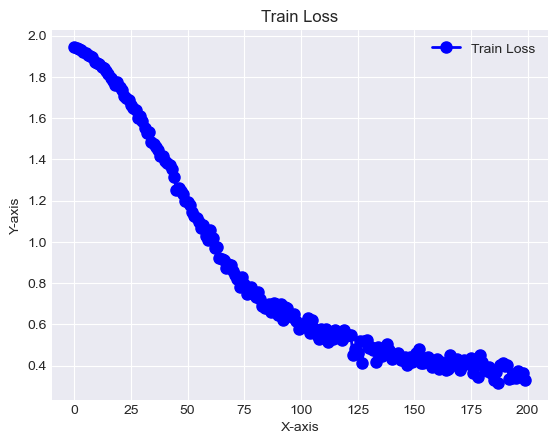

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# 创建一些示例数据
x = np.array(list(range(len(times))))
y = np.array(times)

# 设置样式
plt.style.use('seaborn-darkgrid')  # 使用seaborn风格，也可以选择其他风格

# 绘制折线图
plt.plot(x, y, label='Train Loss', color='blue', linewidth=2, marker='o', markersize=8)

# 添加标题和标签
plt.title('Train Loss')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# 添加图例
plt.legend()

# 显示网格
plt.grid(True)

# 显示图形
plt.show()
